# Рекомендация тарифов

## Цель исследования:
Построить модель для задачи классификации, которая выберет подходящий тариф.

## Ход исследования:
1. Обзор данных. На этом этапе будет проведены обзор, оценка качества данных, оценка возможности использовать данные для машинного обучения. Убедимся в отсутствии необходимости предобработки данных;
2. Разделение исходные данные на обучающую, валидационную и тестовую выборки. На этом этапе будет проведено разделение данных на соответствующие выборки и проверка данных выборок на однородность;
3. Исследование качества моделей. На данном этапе будет предложен ряд алгоритмов машинного обучения, с использованием которых будет проведено обучение моделей, путем подбора гиперпараметров будет осуществляться поиск наиболее точных моделей;
4. Проверка качества модели на тестовой выборке. На этом этапе мы проверим модель, показавшую более точный результат;
5. Проверим модель на вменяемость.

## Описание данных:
Для анализа использованы данные о поведении клиентов, которые уже перешли на эти тарифы. Необходимо постройте модель с максимально большим значением *accuracy* (не менее 0.75).

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:


сalls — количество звонков,


minutes — суммарная длительность звонков в минутах,


messages — количество sms-сообщений,


mb_used — израсходованный интернет-трафик в Мб,


is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Обзор данных

Создадим необходимое окружение для работы:

In [1]:
!pip install sweetviz

In [2]:
!pip install catboost

In [3]:
!pip install pandas-profiling

In [4]:
!pip install yellowbrick

In [5]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import plot_tree
from yellowbrick.classifier import ClassificationReport
import sweetviz as sv

from tqdm import tqdm
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Загрузим и откроем исходные данные.

In [6]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Рассмотрим данные проверим готовность данных к обучению.

In [7]:
report = sv.analyze(df)

                                             |      | [  0%]   00:00 -> (? left)

In [8]:
report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Рассмотрим соотношение классов в выборке.

In [9]:
df.is_ultra.value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Наблюдается дисбаланс в распределении классов. Потребуется учесть дисбаланс и при исследовании моделей добавить определение показателей recall и precision.


Анализ данных показал наличие мультиколлинеарности — явление, при котором наблюдается сильная корреляция между признаками. Сильная корреляция наблюдается у пар признаков (calls & minutes) и столбца is_ultra. Принимаем решение удалить один признак - calls, тем самым избавиться от Мультиколлинеарности, которая негативно влияет на модели машинного обучения.

In [10]:
df = df.drop(columns = ['calls'],axis = 1)

### Вывод

Анализ данных показал, что пропусков нет, дубликатов нет. Контрольное количество строк - 3214, колонок с признаками - 5 (из них 4 с числовыми значениями и 1 колонка "is_ultra" с категориальными значениями). Гистограммы признаков стремятся к нормальному распределению. Аномалий нет. Данные не требуют предобработки.

Для дальнейшей работы требуеся разделить все данные на 3 выборки: на обучающую(60%), валидационную(20%) и тестовую(20%). Обучающая выборка будет использована для разработки модели машинного обучения. Валидационная выборка будет испльзована в процессе разработки модели машинного обучения для подбора оптимального набора гиперпараметров. Тестовая выборка не будет использоваться непосредственно в процессе обучения модели или для подбора гиперпараметров, а будет применяться для тестирования модели - будет контрольной выборкой.


Так как была выявлена мультиколлинеарность было принято решение удалить один признак - calls, тем самым уменьшить негативное влияние на модели машинного обучения.

Для каждой модели будем определять:

accuracy — это главная метрика, которая показывает долю правильных ответов модели. Ее значение равно отношению числа правильных ответов, которые дала модель, к числу всех объектов. Но она не полностью отражает качество модели. Поэтому введем precision и recall.
precision (точность) — эта метрика показывает, насколько мы можем доверять модели, другими словами, какое у нас количество «ложных срабатываний». Значение метрики равно отношению числа ответов, которые модель считает правильными, и они действительно были правильными (это число обозначается «true positives») к сумме «true positives» и числа объектов которые модель посчитала правильными, а на самом деле они были неправильные (это число обозначается «false positives»). В виде формулы: precision = «true positives» / («true positives» + «false positives»).
recall (полнота) — эта метрика показывает насколько модель может вообще обнаруживать правильные ответы, другими словами, какое у нас количество «ложных пропусков». Ее численное значение равно отношению ответов, которые модель считает правильными, и они действительно были правильными к числу всех правильных ответов в выборке. В виде формулы: recall = «true positives» / «all positives».
f1-score (f-мера) — это объединение precision и recall.достигает максимума в 1 при recall и precision, равных 1, и близка к 0, если хотя бы одна из метрик устремлена к 0.
support — просто число найденных объектов в классе.
Чтобы упростить интерпретацию и обнаружение проблем, отчет объединяет числовые оценки с цветовой тепловой картой. Все тепловые карты находятся в диапазоне (0,0, 1,0), чтобы упростить сравнение моделей классификации в разных отчетах о классификации.(если accuracy, precision и recall больше 0.85, то это хорошая модель, если больше 0.95, то отличная.). Отчеты о визуальной классификации будем использовать для сравнения моделей классификации с моделями, которые являются «более красными», т.е. имеют более сильные показатели классификации или более сбалансированы.

## Разделение данных на выборки
Разделим данные случайным образом, сохранив одинаковые доли категориальных значений колонки "is_ultra". 

### Разделим данные на целевую переменную и целевые признаки
Нас интересует выбор пользователей тарифа мобильного оператора. Целевой атрибут будет находится в колонке "is_ultra", где выделяется 2 категории значений: 0 - абонент не пользуется тарифом "Ультра", 1 - пользуется. Атрибуты со свойствами будут находиться во всех остальных колонках.



In [11]:
X = df.drop('is_ultra', axis=1)#целевые признаки features

y = df['is_ultra']#целевая переменная target

### Выделим тестовую выборку

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

Новый сет разделим на обучающую и валидационную выборки.

### Выделим валидационную и обучающую выборки

In [13]:
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, 
                                                    test_size=0.5, random_state=42, stratify=y_valid)

### Оценим количество объектов в выборках и однородность выборок

In [14]:
print('Размер обучающей выборки', len(X_train), ", доля объектов", round((len(X_train)/len(df)*100), 2),'%.')
print('Размер валидационной выборки', len(X_valid), ", доля объектов", round((len(X_valid)/len(df)*100), 2),'%.')
print('Размер тестовой выборки', len(X_test), ", доля объектов", round((len(X_test)/len(df)*100), 2),'%.')

Размер обучающей выборки 1928 , доля объектов 59.99 %.
Размер валидационной выборки 643 , доля объектов 20.01 %.
Размер тестовой выборки 643 , доля объектов 20.01 %.


Удалось получить правильную пропорцию разделения данных.

In [15]:
(len(X_train) + len(X_valid) + len(X_test)) == len(df)

True

### Вывод
Разделили данные на три части: 60% - обучающую выборку, 20% - валидационную выборку, 20% - тестовую выборку.

Выделили целевой атрибут и атрибуты со свойствами. Далее подберем алгоритмы машинного обучения, по-возможности подберем эффективные гиперпараметры и исследуем модели.

## Исследование моделей


Для дальнейшей работы выберем алгоритмы машинного обучения:
1. логистическая регрессия;
2. деревья решений;
3. случайный лес;
4. CatBoost.

Приступим к рассмотрению моделей.

In [16]:
#для удобства вывода в дальнейшем - соберем лучшие показатели точности в списки
table_of_acc_study = []
table_of_model_study = []

### Логистическая регрессия
Рассмотрим модель без настроек гиперпараметров.

In [17]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)


valid_predictions = model.predict(X_valid)
valid_acc = accuracy_score(y_valid, valid_predictions)

print("Точность валидационной выборки без настроек гиперпараметров модели логистической регрессии:", valid_acc)

Точность валидационной выборки без настроек гиперпараметров модели логистической регрессии: 0.749611197511664


Видим, что результат достигает пороговое значение(0,75). Попробуем увеличить точность.

In [18]:
grid = {'penalty':['l1', 'l2', 'elasticnet', 'none'],
        'C':[1.0, 1.2, 1.5, 0.5],
        'solver':['newton-cg', 'lbfgs', 'liblinear' 'sag', 'saga'],
        'intercept_scaling':[1.0, 1.2, 1.5, 0.5]}
model = LogisticRegression(random_state=42)

grid_search = GridSearchCV(model, grid, cv=5,
                           scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [1.0, 1.2, 1.5, 0.5],
                         'intercept_scaling': [1.0, 1.2, 1.5, 0.5],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinearsag',
                                    'saga']},
             scoring='accuracy')

In [19]:
grid_search.best_params_

{'C': 1.0, 'intercept_scaling': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}

Посмотрим, удалось ли увеличить точность:

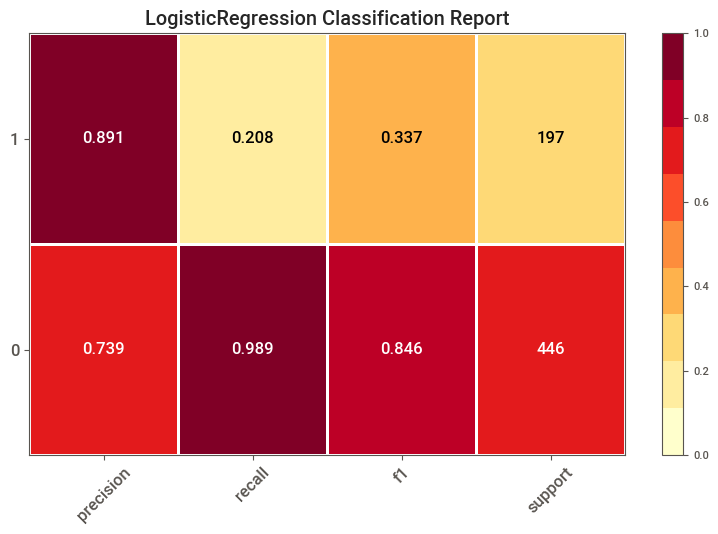

Точность валидационной выборки c настроенными гиперпараметрами модели логистической регрессии: 0.749611197511664


In [20]:
model_logistic = LogisticRegression(random_state=42, C=1.0, intercept_scaling=1.0, penalty='l2', solver='newton-cg')
model_logistic.fit(X_train, y_train)


valid_predictions = model_logistic.predict(X_valid)
valid_acc = accuracy_score(y_valid, valid_predictions)

# Specify the target classes
classes = ["0","1"]

# Instantiate the classification model and visualizer
model = model_logistic
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_valid, y_valid)        # Evaluate the model on the valid data
visualizer.show()                       # Finalize and show the figure


print("Точность валидационной выборки c настроенными гиперпараметрами модели логистической регрессии:", valid_acc)

table_of_acc_study.append(round(valid_acc, 3))
table_of_model_study.append('LogisticRegression')

Настройка гиперпараметров не позволила увеличить точность. Видим, что иные показатели оценки модели особено не сбалансированы для класса-"1".


Лучшая точность модели логистической регрессии  -  0.749611197511664

### Деревья решений
Рассмотрим модель без настроек гиперпараметров.

In [21]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)


valid_predictions = model.predict(X_valid)
valid_acc = accuracy_score(y_valid, valid_predictions)

print("Точность валидационной выборки без настроек гиперпараметров модели дерево решений:", valid_acc)

Точность валидационной выборки без настроек гиперпараметров модели дерево решений: 0.713841368584759


Видим, что результат меньше чем пороговое значение(0,75). Попробуем увеличить точность.

In [22]:
grid = {'criterion':['gini', 'entropy', 'log_loss'],
        'splitter':['best', 'random'],
        'max_depth':range(2, 31),
        'min_samples_split':range(2, 20),
        'min_samples_leaf':range(2, 4)
       }
model = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(model, grid, cv=5,
                           scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(2, 31),
                         'min_samples_leaf': range(2, 4),
                         'min_samples_split': range(2, 20),
                         'splitter': ['best', 'random']},
             scoring='accuracy')

In [23]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_leaf': 2,
 'min_samples_split': 14,
 'splitter': 'random'}

Посмотрим, удалось ли увеличить точность:

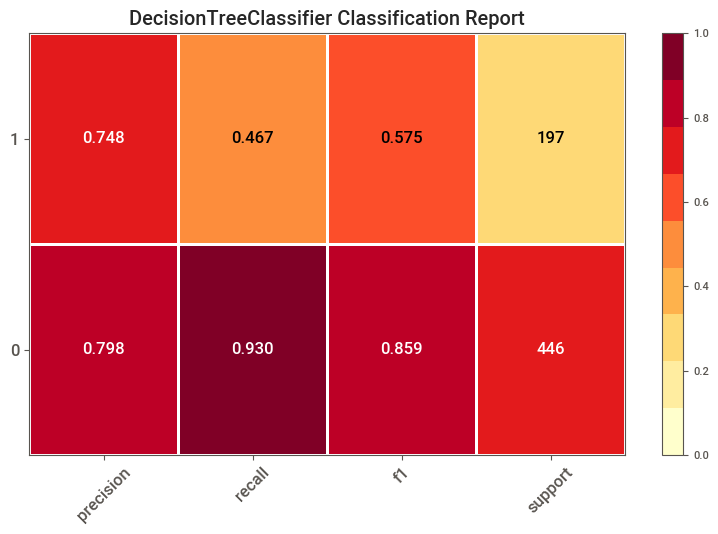

Точность валидационной выборки с настройками гиперпараметров модели дерево решений: 0.7884914463452566


In [24]:
model_tree = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=9,
                               min_samples_leaf=2, min_samples_split=14, splitter='random')
model_tree.fit(X_train, y_train)

valid_predictions = model_tree.predict(X_valid)
valid_acc = accuracy_score(y_valid, valid_predictions)


# Specify the target classes
classes = ["0","1"]

# Instantiate the classification model and visualizer
model = model_tree
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_valid, y_valid)        # Evaluate the model on the valid data
visualizer.show()                       # Finalize and show the figure


print("Точность валидационной выборки с настройками гиперпараметров модели дерево решений:", valid_acc)
table_of_acc_study.append(round(valid_acc, 3))
table_of_model_study.append('DecisionTreeClassifier')

Получено хорошее значение точности, относительно порогового значения(0,75). Лучшая точность модели дерева решений  -  0.7884914463452566.

Видим, что модель более сбалансирована, чем LogisticRegression.

Посмотрим какое дерево удалось построить.

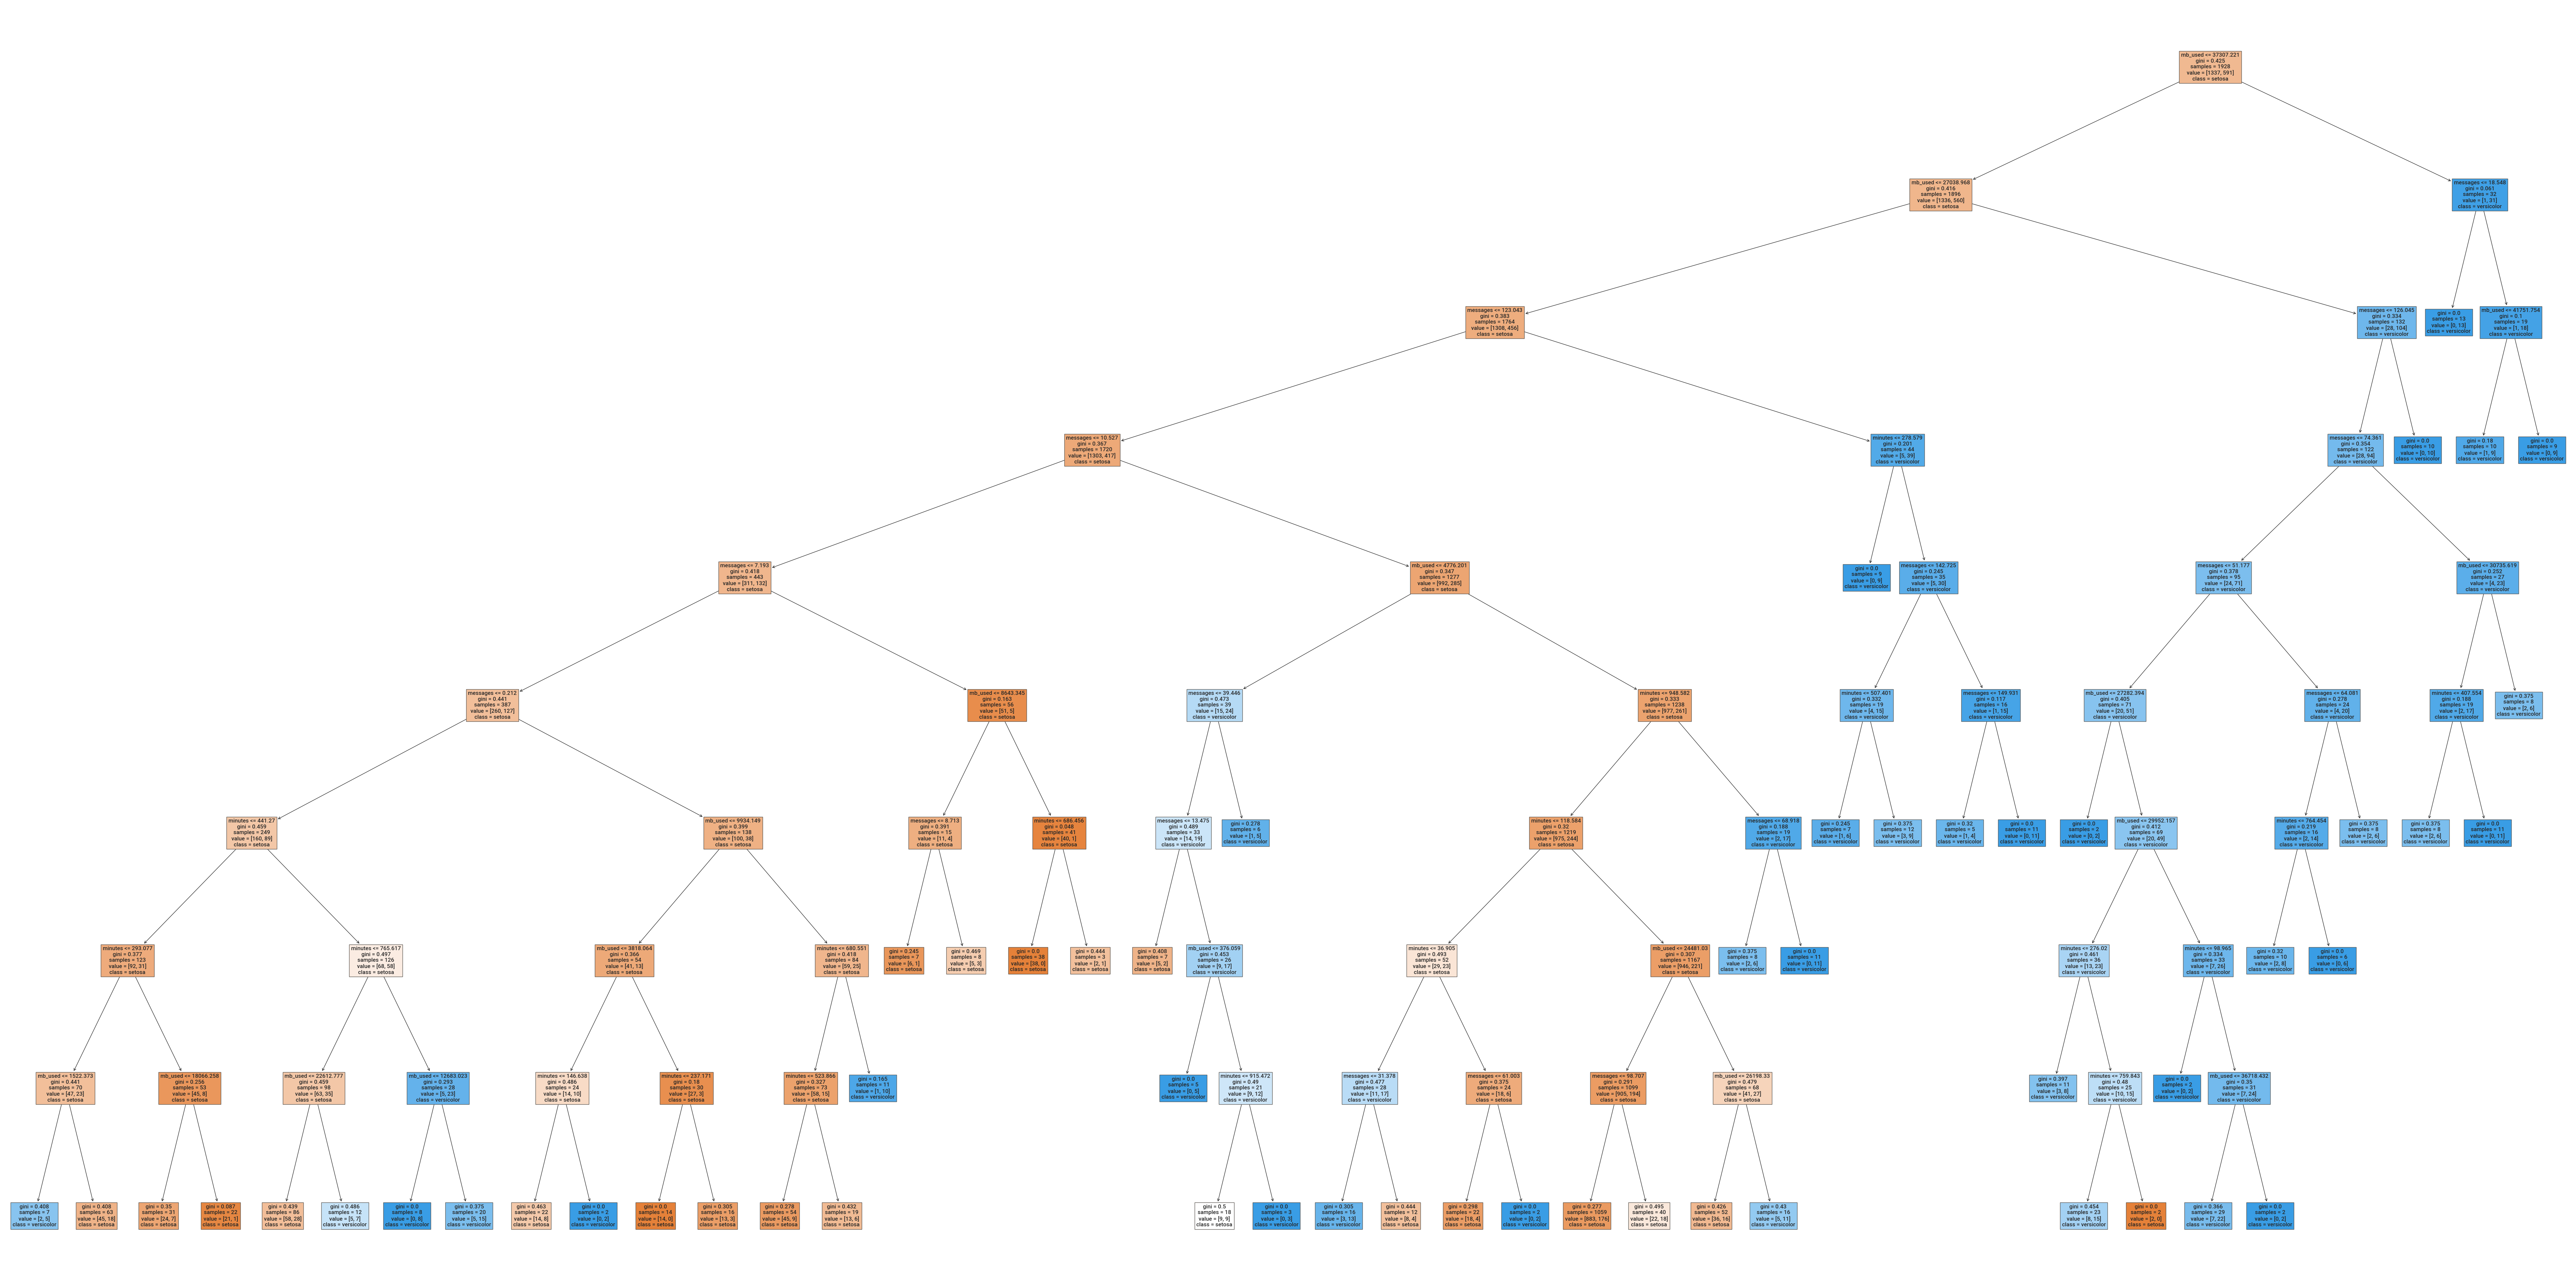

In [25]:
fn = [ 
    'minutes', 
    'messages',
    'mb_used'
]

cn = ['setosa', 'versicolor', 'virginica']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(100, 50))
plot_tree(model_tree, feature_names=fn, class_names=cn, filled=True)
plt.show()

Построение дерева начинается с признака, который сильнее всего влияет на выбор телефонного тарифа - данные из колонки "minutes".


### Случайный лес
Рассмотрим модель без настроек гиперпараметров.

In [26]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


valid_predictions = model.predict(X_valid)
valid_acc = accuracy_score(y_valid, valid_predictions)

print("Точность валидационной выборки без настроек гиперпараметров модели случайный лес:", valid_acc)

Точность валидационной выборки без настроек гиперпараметров модели случайный лес: 0.7853810264385692


Получен хороший результат точности. Посмотрим, получится ли улучшить точность.

In [27]:
grid = {'n_estimators':range(1, 31),
        'criterion': ['gini', 'entropy', 'log_loss'],
        'min_samples_split': range(2, 20),
        }
model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(model, grid, cv=5,
                           scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'min_samples_split': range(2, 20),
                         'n_estimators': range(1, 31)},
             scoring='accuracy')

In [28]:
grid_search.best_params_

{'criterion': 'gini', 'min_samples_split': 18, 'n_estimators': 16}

Посмотрим, удалось ли увеличить точность:

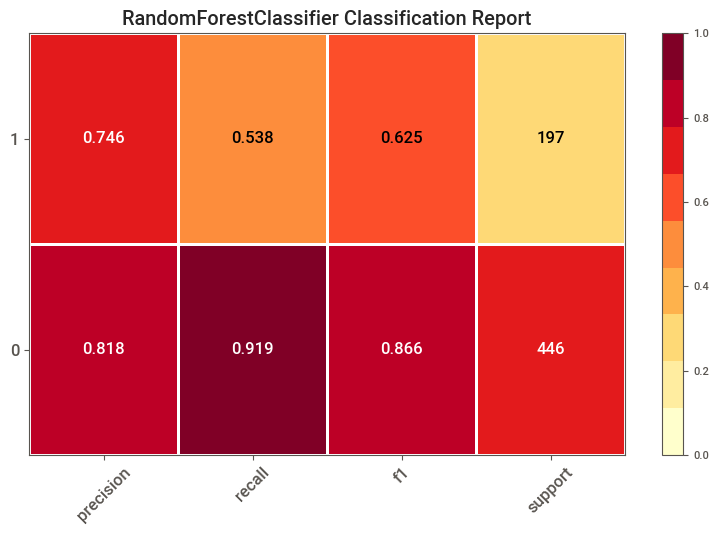

Точность валидационной выборки с настройками гиперпараметров модели случайный лес: 0.80248833592535


In [29]:
model_forest = RandomForestClassifier(random_state=42, criterion='gini', 
                                      min_samples_split=18, n_estimators=16)
model_forest.fit(X_train, y_train)


valid_predictions = model_forest.predict(X_valid)
valid_acc = accuracy_score(y_valid, valid_predictions)

# Specify the target classes
classes = ["0","1"]

# Instantiate the classification model and visualizer
model = model_forest
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_valid, y_valid)        # Evaluate the model on the valid data
visualizer.show()                       # Finalize and show the figure


print("Точность валидационной выборки с настройками гиперпараметров модели случайный лес:", valid_acc)
table_of_acc_study.append(round(valid_acc, 3))
table_of_model_study.append('RandomForestClassifier')

Видим, что модель показывает хороший результат и настройка гиперпараметров показала точность выше. По отдельным показателям сбалансированность лучше чем

Лучшая точность модели случайный лес - 0.80248833592535.


### CatBoost
Рассмотрим модель без настроек гиперпараметров.

In [30]:
model = CatBoostClassifier(random_state=42)
model.fit(X_train, y_train)


valid_predictions = model.predict(X_valid)
valid_acc = accuracy_score(y_valid, valid_predictions)

print("Точность валидационной выборки без настроек гиперпараметров модели CatBoost:", valid_acc)

Learning rate set to 0.013636
0:	learn: 0.6872676	total: 62.3ms	remaining: 1m 2s
1:	learn: 0.6810712	total: 63.8ms	remaining: 31.9s
2:	learn: 0.6754954	total: 65ms	remaining: 21.6s
3:	learn: 0.6702944	total: 65.9ms	remaining: 16.4s
4:	learn: 0.6645277	total: 67.4ms	remaining: 13.4s
5:	learn: 0.6590199	total: 68.2ms	remaining: 11.3s
6:	learn: 0.6541076	total: 68.9ms	remaining: 9.78s
7:	learn: 0.6491542	total: 69.9ms	remaining: 8.67s
8:	learn: 0.6440538	total: 71ms	remaining: 7.82s
9:	learn: 0.6393383	total: 72ms	remaining: 7.12s
10:	learn: 0.6348408	total: 73.2ms	remaining: 6.58s
11:	learn: 0.6302088	total: 74.2ms	remaining: 6.11s
12:	learn: 0.6259951	total: 75.1ms	remaining: 5.7s
13:	learn: 0.6212288	total: 76.2ms	remaining: 5.36s
14:	learn: 0.6177297	total: 77.7ms	remaining: 5.1s
15:	learn: 0.6138273	total: 79ms	remaining: 4.86s
16:	learn: 0.6097161	total: 80.1ms	remaining: 4.63s
17:	learn: 0.6061109	total: 81.3ms	remaining: 4.43s
18:	learn: 0.6022287	total: 82.4ms	remaining: 4.25s
19

253:	learn: 0.4169082	total: 376ms	remaining: 1.1s
254:	learn: 0.4167784	total: 378ms	remaining: 1.1s
255:	learn: 0.4166335	total: 378ms	remaining: 1.1s
256:	learn: 0.4164191	total: 380ms	remaining: 1.1s
257:	learn: 0.4162063	total: 381ms	remaining: 1.1s
258:	learn: 0.4159701	total: 383ms	remaining: 1.09s
259:	learn: 0.4158394	total: 384ms	remaining: 1.09s
260:	learn: 0.4155953	total: 385ms	remaining: 1.09s
261:	learn: 0.4154214	total: 386ms	remaining: 1.09s
262:	learn: 0.4152667	total: 388ms	remaining: 1.09s
263:	learn: 0.4151143	total: 390ms	remaining: 1.09s
264:	learn: 0.4149966	total: 391ms	remaining: 1.08s
265:	learn: 0.4147707	total: 392ms	remaining: 1.08s
266:	learn: 0.4146080	total: 394ms	remaining: 1.08s
267:	learn: 0.4144646	total: 395ms	remaining: 1.08s
268:	learn: 0.4142912	total: 396ms	remaining: 1.08s
269:	learn: 0.4140134	total: 397ms	remaining: 1.07s
270:	learn: 0.4138183	total: 399ms	remaining: 1.07s
271:	learn: 0.4135774	total: 400ms	remaining: 1.07s
272:	learn: 0.413

413:	learn: 0.3937419	total: 569ms	remaining: 806ms
414:	learn: 0.3936646	total: 570ms	remaining: 804ms
415:	learn: 0.3935814	total: 571ms	remaining: 802ms
416:	learn: 0.3934623	total: 572ms	remaining: 800ms
417:	learn: 0.3932131	total: 573ms	remaining: 797ms
418:	learn: 0.3931149	total: 574ms	remaining: 795ms
419:	learn: 0.3930469	total: 574ms	remaining: 793ms
420:	learn: 0.3929212	total: 575ms	remaining: 791ms
421:	learn: 0.3928339	total: 576ms	remaining: 789ms
422:	learn: 0.3927014	total: 577ms	remaining: 787ms
423:	learn: 0.3925978	total: 578ms	remaining: 785ms
424:	learn: 0.3924862	total: 578ms	remaining: 783ms
425:	learn: 0.3923908	total: 579ms	remaining: 781ms
426:	learn: 0.3923466	total: 581ms	remaining: 779ms
427:	learn: 0.3922699	total: 582ms	remaining: 777ms
428:	learn: 0.3921705	total: 583ms	remaining: 775ms
429:	learn: 0.3920211	total: 583ms	remaining: 773ms
430:	learn: 0.3919057	total: 584ms	remaining: 772ms
431:	learn: 0.3916701	total: 585ms	remaining: 770ms
432:	learn: 

577:	learn: 0.3736772	total: 763ms	remaining: 557ms
578:	learn: 0.3735880	total: 766ms	remaining: 557ms
579:	learn: 0.3734315	total: 767ms	remaining: 555ms
580:	learn: 0.3733120	total: 768ms	remaining: 554ms
581:	learn: 0.3732197	total: 770ms	remaining: 553ms
582:	learn: 0.3730500	total: 771ms	remaining: 552ms
583:	learn: 0.3729572	total: 773ms	remaining: 550ms
584:	learn: 0.3728451	total: 774ms	remaining: 549ms
585:	learn: 0.3728058	total: 776ms	remaining: 548ms
586:	learn: 0.3726855	total: 777ms	remaining: 547ms
587:	learn: 0.3725693	total: 778ms	remaining: 545ms
588:	learn: 0.3725067	total: 779ms	remaining: 544ms
589:	learn: 0.3724101	total: 780ms	remaining: 542ms
590:	learn: 0.3722710	total: 781ms	remaining: 541ms
591:	learn: 0.3721567	total: 783ms	remaining: 539ms
592:	learn: 0.3719680	total: 784ms	remaining: 538ms
593:	learn: 0.3718824	total: 785ms	remaining: 536ms
594:	learn: 0.3717405	total: 786ms	remaining: 535ms
595:	learn: 0.3716573	total: 787ms	remaining: 534ms
596:	learn: 

740:	learn: 0.3521097	total: 967ms	remaining: 338ms
741:	learn: 0.3519375	total: 968ms	remaining: 337ms
742:	learn: 0.3518314	total: 970ms	remaining: 335ms
743:	learn: 0.3516935	total: 971ms	remaining: 334ms
744:	learn: 0.3516019	total: 972ms	remaining: 333ms
745:	learn: 0.3513652	total: 973ms	remaining: 331ms
746:	learn: 0.3511370	total: 974ms	remaining: 330ms
747:	learn: 0.3509847	total: 976ms	remaining: 329ms
748:	learn: 0.3508008	total: 977ms	remaining: 327ms
749:	learn: 0.3506329	total: 978ms	remaining: 326ms
750:	learn: 0.3505171	total: 980ms	remaining: 325ms
751:	learn: 0.3504113	total: 981ms	remaining: 323ms
752:	learn: 0.3503135	total: 982ms	remaining: 322ms
753:	learn: 0.3501166	total: 983ms	remaining: 321ms
754:	learn: 0.3498716	total: 984ms	remaining: 319ms
755:	learn: 0.3497044	total: 985ms	remaining: 318ms
756:	learn: 0.3495783	total: 986ms	remaining: 317ms
757:	learn: 0.3494380	total: 988ms	remaining: 315ms
758:	learn: 0.3493572	total: 989ms	remaining: 314ms
759:	learn: 

899:	learn: 0.3314460	total: 1.15s	remaining: 128ms
900:	learn: 0.3313338	total: 1.17s	remaining: 129ms
901:	learn: 0.3312263	total: 1.17s	remaining: 127ms
902:	learn: 0.3311045	total: 1.17s	remaining: 126ms
903:	learn: 0.3309888	total: 1.17s	remaining: 125ms
904:	learn: 0.3308519	total: 1.17s	remaining: 123ms
905:	learn: 0.3308304	total: 1.18s	remaining: 122ms
906:	learn: 0.3307634	total: 1.18s	remaining: 121ms
907:	learn: 0.3306664	total: 1.18s	remaining: 119ms
908:	learn: 0.3305328	total: 1.18s	remaining: 118ms
909:	learn: 0.3304912	total: 1.18s	remaining: 117ms
910:	learn: 0.3304134	total: 1.18s	remaining: 115ms
911:	learn: 0.3303105	total: 1.18s	remaining: 114ms
912:	learn: 0.3301540	total: 1.18s	remaining: 112ms
913:	learn: 0.3300034	total: 1.18s	remaining: 111ms
914:	learn: 0.3298467	total: 1.18s	remaining: 110ms
915:	learn: 0.3297958	total: 1.18s	remaining: 108ms
916:	learn: 0.3296670	total: 1.18s	remaining: 107ms
917:	learn: 0.3295404	total: 1.18s	remaining: 106ms
918:	learn: 

Получен хороший результат точности. Посмотрим, получится ли увеличить точность.

In [31]:
grid = {'metric_period':[10, 50, 100],
        'verbose': [10, 50, 100]
        }
model = CatBoostClassifier(random_state=42)

grid_search = GridSearchCV(model, grid, cv=5,
                           scoring='accuracy')
grid_search.fit(X_train, y_train)

Learning rate set to 0.012395
0:	learn: 0.6879206	total: 1.44ms	remaining: 1.44s
10:	learn: 0.6414320	total: 9.64ms	remaining: 867ms
20:	learn: 0.6030555	total: 17.3ms	remaining: 808ms
30:	learn: 0.5732302	total: 45.4ms	remaining: 1.42s
40:	learn: 0.5510636	total: 56.5ms	remaining: 1.32s
50:	learn: 0.5328035	total: 68.5ms	remaining: 1.27s
60:	learn: 0.5175884	total: 80.6ms	remaining: 1.24s
70:	learn: 0.5049445	total: 89.9ms	remaining: 1.18s
80:	learn: 0.4940389	total: 102ms	remaining: 1.16s
90:	learn: 0.4849097	total: 112ms	remaining: 1.12s
100:	learn: 0.4770440	total: 126ms	remaining: 1.12s
110:	learn: 0.4709435	total: 137ms	remaining: 1.1s
120:	learn: 0.4648174	total: 150ms	remaining: 1.09s
130:	learn: 0.4595181	total: 161ms	remaining: 1.07s
140:	learn: 0.4545745	total: 171ms	remaining: 1.04s
150:	learn: 0.4502696	total: 181ms	remaining: 1.02s
160:	learn: 0.4463182	total: 193ms	remaining: 1.01s
170:	learn: 0.4425450	total: 202ms	remaining: 982ms
180:	learn: 0.4390372	total: 211ms	rem

660:	learn: 0.3768149	total: 800ms	remaining: 410ms
670:	learn: 0.3756492	total: 812ms	remaining: 398ms
680:	learn: 0.3743629	total: 824ms	remaining: 386ms
690:	learn: 0.3730567	total: 834ms	remaining: 373ms
700:	learn: 0.3719384	total: 845ms	remaining: 360ms
710:	learn: 0.3707181	total: 856ms	remaining: 348ms
720:	learn: 0.3695068	total: 867ms	remaining: 336ms
730:	learn: 0.3683288	total: 882ms	remaining: 325ms
740:	learn: 0.3672956	total: 894ms	remaining: 312ms
750:	learn: 0.3660541	total: 908ms	remaining: 301ms
760:	learn: 0.3645609	total: 919ms	remaining: 289ms
770:	learn: 0.3632112	total: 929ms	remaining: 276ms
780:	learn: 0.3619945	total: 941ms	remaining: 264ms
790:	learn: 0.3608463	total: 954ms	remaining: 252ms
800:	learn: 0.3595517	total: 964ms	remaining: 239ms
810:	learn: 0.3583001	total: 971ms	remaining: 226ms
820:	learn: 0.3569924	total: 979ms	remaining: 213ms
830:	learn: 0.3556995	total: 986ms	remaining: 201ms
840:	learn: 0.3543864	total: 994ms	remaining: 188ms
850:	learn: 

270:	learn: 0.4074768	total: 317ms	remaining: 853ms
280:	learn: 0.4054517	total: 329ms	remaining: 842ms
290:	learn: 0.4037035	total: 339ms	remaining: 827ms
300:	learn: 0.4016842	total: 352ms	remaining: 817ms
310:	learn: 0.3995301	total: 363ms	remaining: 804ms
320:	learn: 0.3977114	total: 374ms	remaining: 790ms
330:	learn: 0.3961721	total: 386ms	remaining: 780ms
340:	learn: 0.3946524	total: 397ms	remaining: 767ms
350:	learn: 0.3932284	total: 409ms	remaining: 757ms
360:	learn: 0.3916568	total: 417ms	remaining: 739ms
370:	learn: 0.3901718	total: 425ms	remaining: 721ms
380:	learn: 0.3888103	total: 434ms	remaining: 705ms
390:	learn: 0.3876176	total: 441ms	remaining: 687ms
400:	learn: 0.3860820	total: 449ms	remaining: 670ms
410:	learn: 0.3847745	total: 456ms	remaining: 654ms
420:	learn: 0.3832442	total: 465ms	remaining: 640ms
430:	learn: 0.3818846	total: 477ms	remaining: 629ms
440:	learn: 0.3805627	total: 488ms	remaining: 619ms
450:	learn: 0.3792903	total: 500ms	remaining: 608ms
460:	learn: 

930:	learn: 0.3171483	total: 1.09s	remaining: 80.6ms
940:	learn: 0.3156619	total: 1.1s	remaining: 68.9ms
950:	learn: 0.3143037	total: 1.11s	remaining: 57.2ms
960:	learn: 0.3128859	total: 1.12s	remaining: 45.5ms
970:	learn: 0.3114942	total: 1.13s	remaining: 33.9ms
980:	learn: 0.3103008	total: 1.14s	remaining: 22.2ms
990:	learn: 0.3090387	total: 1.16s	remaining: 10.5ms
999:	learn: 0.3078385	total: 1.17s	remaining: 0us
Learning rate set to 0.012395
0:	learn: 0.6879206	total: 1.06ms	remaining: 1.06s
50:	learn: 0.5328035	total: 56.1ms	remaining: 1.04s
100:	learn: 0.4770440	total: 115ms	remaining: 1.02s
150:	learn: 0.4502696	total: 182ms	remaining: 1.02s
200:	learn: 0.4331313	total: 243ms	remaining: 965ms
250:	learn: 0.4212358	total: 301ms	remaining: 897ms
300:	learn: 0.4112621	total: 358ms	remaining: 832ms
350:	learn: 0.4034748	total: 420ms	remaining: 777ms
400:	learn: 0.3960911	total: 474ms	remaining: 708ms
450:	learn: 0.3893606	total: 533ms	remaining: 648ms
500:	learn: 0.3832685	total: 58

700:	learn: 0.3469324	total: 795ms	remaining: 339ms
800:	learn: 0.3335270	total: 915ms	remaining: 227ms
900:	learn: 0.3195839	total: 1.03s	remaining: 114ms
999:	learn: 0.3065921	total: 1.15s	remaining: 0us
Learning rate set to 0.012398
0:	learn: 0.6873637	total: 1.23ms	remaining: 1.23s
100:	learn: 0.4692964	total: 113ms	remaining: 1.01s
200:	learn: 0.4274210	total: 227ms	remaining: 904ms
300:	learn: 0.4055418	total: 343ms	remaining: 797ms
400:	learn: 0.3905287	total: 452ms	remaining: 675ms
500:	learn: 0.3766196	total: 569ms	remaining: 567ms
600:	learn: 0.3633759	total: 684ms	remaining: 454ms
700:	learn: 0.3489705	total: 806ms	remaining: 344ms
800:	learn: 0.3346922	total: 921ms	remaining: 229ms
900:	learn: 0.3208804	total: 1.04s	remaining: 114ms
999:	learn: 0.3078385	total: 1.15s	remaining: 0us
Learning rate set to 0.012395
0:	learn: 0.6879206	total: 1.03ms	remaining: 1.03s
50:	learn: 0.5328035	total: 53.2ms	remaining: 989ms
100:	learn: 0.4770440	total: 107ms	remaining: 956ms
150:	learn

100:	learn: 0.4684301	total: 113ms	remaining: 1s
200:	learn: 0.4235407	total: 228ms	remaining: 908ms
300:	learn: 0.4016842	total: 333ms	remaining: 773ms
400:	learn: 0.3860820	total: 454ms	remaining: 677ms
500:	learn: 0.3724996	total: 563ms	remaining: 560ms
600:	learn: 0.3599724	total: 665ms	remaining: 441ms
700:	learn: 0.3469324	total: 767ms	remaining: 327ms
800:	learn: 0.3335270	total: 882ms	remaining: 219ms
900:	learn: 0.3195839	total: 992ms	remaining: 109ms
999:	learn: 0.3065921	total: 1.11s	remaining: 0us
Learning rate set to 0.012398
0:	learn: 0.6873637	total: 1.65ms	remaining: 1.65s
100:	learn: 0.4692964	total: 118ms	remaining: 1.05s
200:	learn: 0.4274210	total: 245ms	remaining: 974ms
300:	learn: 0.4055418	total: 356ms	remaining: 826ms
400:	learn: 0.3905287	total: 479ms	remaining: 715ms
500:	learn: 0.3766196	total: 591ms	remaining: 588ms
600:	learn: 0.3633759	total: 721ms	remaining: 479ms
700:	learn: 0.3489705	total: 840ms	remaining: 358ms
800:	learn: 0.3346922	total: 945ms	remai

860:	learn: 0.3361759	total: 1.11s	remaining: 179ms
870:	learn: 0.3350025	total: 1.13s	remaining: 168ms
880:	learn: 0.3337776	total: 1.14s	remaining: 155ms
890:	learn: 0.3323953	total: 1.16s	remaining: 141ms
900:	learn: 0.3313338	total: 1.17s	remaining: 128ms
910:	learn: 0.3304134	total: 1.18s	remaining: 115ms
920:	learn: 0.3291355	total: 1.19s	remaining: 102ms
930:	learn: 0.3280585	total: 1.21s	remaining: 89.9ms
940:	learn: 0.3268932	total: 1.23s	remaining: 76.9ms
950:	learn: 0.3256755	total: 1.24s	remaining: 63.9ms
960:	learn: 0.3242960	total: 1.25s	remaining: 50.8ms
970:	learn: 0.3230964	total: 1.26s	remaining: 37.8ms
980:	learn: 0.3219690	total: 1.27s	remaining: 24.7ms
990:	learn: 0.3206914	total: 1.29s	remaining: 11.7ms
999:	learn: 0.3198760	total: 1.3s	remaining: 0us


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fd72eb020a0>,
             param_grid={'metric_period': [10, 50, 100],
                         'verbose': [10, 50, 100]},
             scoring='accuracy')

In [32]:
grid_search.best_params_

{'metric_period': 10, 'verbose': 10}

Посмотрим, удалось ли увеличить точность:

Learning rate set to 0.013636
0:	learn: 0.6872676	total: 1.94ms	remaining: 1.94s
10:	learn: 0.6348408	total: 13ms	remaining: 1.17s
20:	learn: 0.5946006	total: 25.5ms	remaining: 1.19s
30:	learn: 0.5632813	total: 38.3ms	remaining: 1.2s
40:	learn: 0.5399328	total: 55.3ms	remaining: 1.29s
50:	learn: 0.5205725	total: 68.3ms	remaining: 1.27s
60:	learn: 0.5056463	total: 80.8ms	remaining: 1.24s
70:	learn: 0.4938431	total: 93.8ms	remaining: 1.23s
80:	learn: 0.4837167	total: 115ms	remaining: 1.31s
90:	learn: 0.4751738	total: 128ms	remaining: 1.27s
100:	learn: 0.4680148	total: 139ms	remaining: 1.24s
110:	learn: 0.4618285	total: 151ms	remaining: 1.21s
120:	learn: 0.4561287	total: 165ms	remaining: 1.2s
130:	learn: 0.4515578	total: 178ms	remaining: 1.18s
140:	learn: 0.4471633	total: 190ms	remaining: 1.16s
150:	learn: 0.4433483	total: 207ms	remaining: 1.16s
160:	learn: 0.4399462	total: 220ms	remaining: 1.15s
170:	learn: 0.4367262	total: 234ms	remaining: 1.13s
180:	learn: 0.4338567	total: 245ms	remain

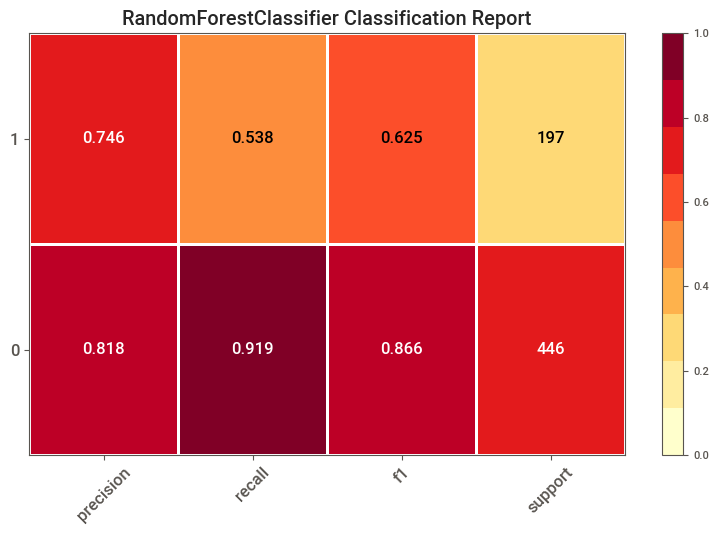

Точность валидационной выборки с настройками гиперпараметров модели CatBoost: 0.8087091757387247


In [33]:
model_cat = CatBoostClassifier(random_state=42, metric_period=10, verbose=10)
model_cat.fit(X_train, y_train)


valid_predictions = model_cat.predict(X_valid)
valid_acc = accuracy_score(y_valid, valid_predictions)

# Specify the target classes
classes = ["0","1"]

# Instantiate the classification model and visualizer
model = model_forest
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_valid, y_valid)        # Evaluate the model on the valid data
visualizer.show()                       # Finalize and show the figure

print("Точность валидационной выборки с настройками гиперпараметров модели CatBoost:", valid_acc)
table_of_acc_study.append(round(valid_acc, 3))
table_of_model_study.append('CatBoostClassifier')

Видим, что модель показывает хороший результат и настройка гиперпараметров показала значение близкое к значению точности без настройки гиперпараметров. Это говорит о том, что модель самостоятельно хорошо обучается. Лучшая точность модели CatBoost - 0.8087091757387247. Видим, что точность модели CatBoost - самая высокая.


### Вывод
В результате исследования моделей, путем подбора гиперпараметров удалось получить максимальные значения точности:

In [34]:
table_of_models_study = (pd.DataFrame({' Модель':table_of_model_study, 'Точность':table_of_acc_study, }).
                         sort_values(by='Точность', ascending=False).
                  reset_index(drop=True))
table_of_models_study

,Модель,Точность
0,CatBoostClassifier,0.809
1,RandomForestClassifier,0.802
2,DecisionTreeClassifier,0.788
3,LogisticRegression,0.750


Видим, что все модели, кроме LogisticRegression показали хороший результат, относительно порогового значения (0,75). Лидирует по показателю точности модель CatBoost. Сбалансированность модели - самая лучшая из рассмотренных. Именно эту модель проверим на тестовой выборке и посмотриим, будет ли результат точности таким же высоким.


## Проверка модели на тестовой выборке


In [35]:
test_predictions = model_cat.predict(X_test)
test_acc = accuracy_score(y_test, test_predictions)

print("Точность наилучшей модели на тестовой выборке:", test_acc)


Точность наилучшей модели на тестовой выборке: 0.8118195956454122


### Вывод
Проверка на тестовой выборке показала  высокую точность, что подтверждает правильность выбора модели CatBoost для обучения и то, что модель очень хорошо обучается самостоятельно. Точность модели на тестовой выборке - 0.8118195956454122, точность модели на валидационной выборке - 0.8087091757387247.


## Проверка модели на адекватность
Проверим модели на адекватность. Для это построим случайную модель на основе DummyClassifier.DummyClassifier-это классификатор,который делает прогнозы, используя простые правила. Классификатор полезен в качестве простой основы для сравнения с другими (реальными)классификаторами.


Рассмотрим значения точности различных стратегий для данного алгоритма и сравним результаты с точностью модели CatBoost:

In [36]:
strategies = ['most_frequent', 'prior', 'stratified', 'uniform', 'constant']
dummies_result = []
for strat in strategies:
    dc = DummyClassifier(random_state=42)
    dc.fit(X_train, y_train)
    res = dc.score(X_test, y_test)
    dummies_result.append({strat:res})

pd.DataFrame(dummies_result).fillna(0)

,most_frequent,prior,stratified,uniform,constant
0,0.693624,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.693624,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.693624,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.693624,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.693624


Из таблицы, мы видим, что с помощью DummyClassifier мы получили максимальное значение 0.693624. Значения полученные с использованием DummyClassifier не достигают порогового значения(0,75). Точность CatBoost значительно выше - 0.8118195956454122.


### Вывод
Мы видим, точность CatBoost выше чем данные, полученные с использованием DummyClassifier. Делаем вывод о том, что модель CatBoost можно считать вменяемой(адекватной).


## Общий вывод

На этапе обзора данных было установлено, что пропусков в данных нет, отсутствуют дубликаты. Данные содержат 3214 строк, 5 колонок с признаками (из них 4 с числовыми значениями и 1 колонка "is_ultra" с категориальными значениями). Гистограммы признаков стремятся к нормальному распределению. Аномалий нет. Данные не требуют предобработки.Так как была выявлена мультиколлинеарность было принято решение удалить один признак - calls, тем самым уменьшить негативное влияние на модели машинного обучения.


На этапе  - разделение исходные данные на выборки, были разделены данные на три части: 60% - обучающую выборку, 20% - валидационную выборку, 20% - тестовую выборку. Добились однородности всех выборок, согласно подсчету доли абонентов использующих тариф "Ультра".

Исследование качества моделей включало:
1. разделение обучающей и валидирующущей выборки на целевой атрибут и атрибуты со свойствами для построение моделей. Целевой атрибут находится в колонке "is_ultra", где выделяется 2 категории значений: 0 - абонент не пользуется тарифом "Ультра", 1 - пользуется. Атрибуты со свойствами находяться во всех остальных колонках;
2. Были определены алгоритмы машинного обучения для анализа: логистическая регрессия; деревья решений; случайный лес; CatBoost;
3. В результате исследования моделей, путем подбора гиперпараметров удалось получить максимальные значения точности:

In [37]:
table_of_models_study

,Модель,Точность
0,CatBoostClassifier,0.809
1,RandomForestClassifier,0.802
2,DecisionTreeClassifier,0.788
3,LogisticRegression,0.750


Данный анализ позволил установить, что все модели, кроме LogisticRegression показали хороший результат, относительно порогового значения (0,75). Самый высокий показатель точности достигла модель CatBoost. 


Проверка качества лучшей модели CatBoost на тестовой выборке требовала разделения тестовой выборки на целевой атрибут и атрибуты со свойствами для построение моделей. В результате проверки модель показала высокую точность и подтвердила правильность выбора модели для обучения.

Полученные результаты свидетельствуют о том, что для задачи классификации, которая требует выбора подходящего тарифа можно использовать модель CatBoost, которая показала высокий уровень точности.

Исследование модели на вменяемость(адекватность)проводилось с помощью DummyClassifier.  Мы получили максимальное значение 0.707621 и значения, полученные с использованием DummyClassifier, не достигли порогового значения(0,75). Точность модели CatBoost оказалась значительно выше - 0.8118195956454122. Эти данные свидетельствуют о вменяемости(адекватности) модели CatBoost.
